<a href="https://colab.research.google.com/github/haokeliu/colaboratory/blob/master/DeepLearn_Notes/%E6%95%B0%E6%8D%AE%E5%92%8C%E6%A8%A1%E5%9E%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#Load pytorch library
!pip3 install torch

In [0]:
from argparse import Namespace
import collections
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import torch

In [0]:
# Set Numpy and PyTorch seeds
def set_seeds(seed,cuda):
  np.random.seed(seed)
  torch.manual_seed(seed)
  if cuda:
    torch.cuda.manual_seed_all(seed)

In [4]:
#Arguments
args = Namespace(
    seed = 1234,
    cuda = False,
    shuffle = True,
    data_file = 'tumors.csv',
    reduced_data_file = 'tumors_reduced.csv',
    train_size = 0.75,
    test_size = 0.25,
    num_hidden_units = 100,
    learning_rate = 1e-3,
    num_epochs = 100,
)
set_seeds(seed = args.seed, cuda = args.cuda)
# Check CUDA
if not torch.cuda.is_available():
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: False


In [0]:
import re
import urllib

In [0]:
#upload data from Github to notebook's local drive
url = "https://raw.githubusercontent.com/GokuMohandas/practicalAI/master/data/tumors.csv"
response = urllib.request.urlopen(url)
html = response.read()
with open(args.data_file,'wb') as fp:
  fp.write(html)

In [7]:
# Raw data
df = pd.read_csv(args.data_file, header =0)
df.head()

,leukocyte_count,blood_pressure,tumor
0,13.472969,15.250393,1
1,10.805510,14.109676,1
2,13.834053,15.793920,1
3,9.572811,17.873286,1
4,7.633667,16.598559,1


In [0]:
def plot_tumors(df):
    i = 0; colors=['r', 'b']
    for name, group in df.groupby("tumor"):
        plt.scatter(group.leukocyte_count, group.blood_pressure, edgecolors='k',
                   color=colors[i]); i += 1
    plt.xlabel('leukocyte count')
    plt.ylabel('blood pressure')
    plt.legend(['0 - benign', '1 - malignant'], loc="upper right")
    plt.show()

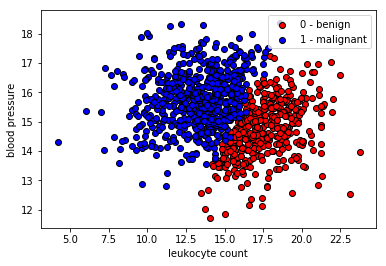

In [9]:
# Plot data
plot_tumors(df)

In [11]:
#Convert to PyTorch tensors
X = df.as_matrix(columns=['leukocyte_count', 'blood_pressure'])
y = df.as_matrix(columns=['tumor'])
X = torch.from_numpy(X).float()
y = torch.from_numpy(y.ravel()).long()
# numpy中的ravel()、flatten()、squeeze()都有将多维数组转换为一维数组的功能，区别： 
# ravel()：如果没有必要，不会产生源数据的副本 
# flatten()：返回源数据的副本 
# squeeze()：只能对维数为1的维度降维

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


In [13]:
# 打乱数据 Shuffle data
shuffle_indicies = torch.LongTensor(random.sample(range(0, len(X)), len(X)))
X = X[shuffle_indicies]
y = y[shuffle_indicies]

# Split datasets
test_start_idx = int(len(X) * args.train_size)
X_train = X[:test_start_idx] 
y_train = y[:test_start_idx] 
X_test = X[test_start_idx:] 
y_test = y[test_start_idx:]
print("We have %i train samples and %i test samples." % (len(X_train), len(X_test)))

We have 750 train samples and 250 test samples.


# 模型 Model
基于这个人造数据训练模型。

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader

In [0]:
# 多层感知 Multilayer Perceptron 
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x_in, apply_softmax=False):
        a_1 = F.relu(self.fc1(x_in)) # activaton function added!
        y_pred = self.fc2(a_1)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return y_pred

In [0]:
# Initialize model
model = MLP(input_dim=len(df.columns)-1, 
            hidden_dim=args.num_hidden_units, 
            output_dim=len(set(df.tumor)))

In [0]:
# Optimization
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate) 

In [0]:
# Accuracy
def get_accuracy(y_pred, y_target):
    n_correct = torch.eq(y_pred, y_target).sum().item()
    accuracy = n_correct / len(y_pred) * 100
    return accuracy

In [21]:
# Training
for t in range(args.num_epochs):
    # Forward pass
    y_pred = model(X_train)
    
    # Accuracy
    _, predictions = y_pred.max(dim=1)
    accuracy = get_accuracy(y_pred=predictions.long(), y_target=y_train)

    # Loss
    loss = loss_fn(y_pred, y_train)
    
    # Verbose
    if t%20==0: 
        print ("epoch: {0:02d} | loss: {1:.4f} | accuracy: {2:.1f}%".format(
            t, loss, accuracy))

    # Zero all gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update weights
    optimizer.step()

epoch: 00 | loss: 0.1357 | accuracy: 98.9%
epoch: 20 | loss: 0.1170 | accuracy: 99.1%
epoch: 40 | loss: 0.1064 | accuracy: 99.1%
epoch: 60 | loss: 0.0985 | accuracy: 99.1%
epoch: 80 | loss: 0.0922 | accuracy: 99.1%


In [0]:
# Predictions
_, pred_train = model(X_train, apply_softmax=True).max(dim=1)
_, pred_test = model(X_test, apply_softmax=True).max(dim=1)

In [23]:
# Train and test accuracies
train_acc = get_accuracy(y_pred=pred_train, y_target=y_train)
test_acc = get_accuracy(y_pred=pred_test, y_target=y_test)
print ("train acc: {0:.1f}%, test acc: {1:.1f}%".format(train_acc, test_acc))

train acc: 99.2%, test acc: 98.4%


In [0]:
# Visualization
def plot_multiclass_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    cmap = plt.cm.Spectral
    
    X_test = torch.from_numpy(np.c_[xx.ravel(), yy.ravel()]).float()
    y_pred = model(X_test, apply_softmax=True)
    _, y_pred = y_pred.max(dim=1)
    y_pred = y_pred.reshape(xx.shape)
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.Spectral, alpha=0.8)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

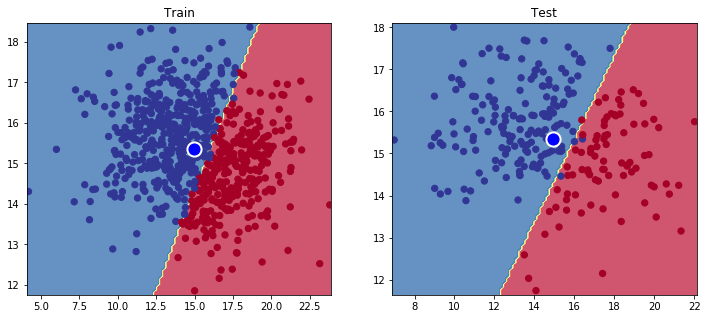

In [25]:
# Visualize the decision boundary
plt.figure(figsize=(12,5))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_multiclass_decision_boundary(model=model, X=X_train, y=y_train)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_multiclass_decision_boundary(model=model, X=X_test, y=y_test)
plt.scatter(np.mean(df.leukocyte_count), np.mean(df.blood_pressure), s=200, 
            c='b', edgecolor='w', linewidth=2)
plt.show()